In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from util import cap_outliers_percentile, impute_median, label_encode_columns, min_max_scale_columns
from models.random_forest import RandomForest
from models.xg_boost import XGBoost
from models.light_gbm import LightGBM
from models.linear_regression import LinearRegressionModel
import shap

In [2]:
seed = 1000
np.random.seed(seed)
random.seed(seed)

### Load Data

In [3]:
path = kagglehub.dataset_download("harishkumardatalab/housing-price-prediction")
print("Files:", os.listdir(path))

csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

Files: ['Housing.csv']


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


### EDA

In [5]:
df.describe(include="object")

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,545,545,545,545,545,545,545
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,468,448,354,520,373,417,227


In [6]:
df.describe(include='number')

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


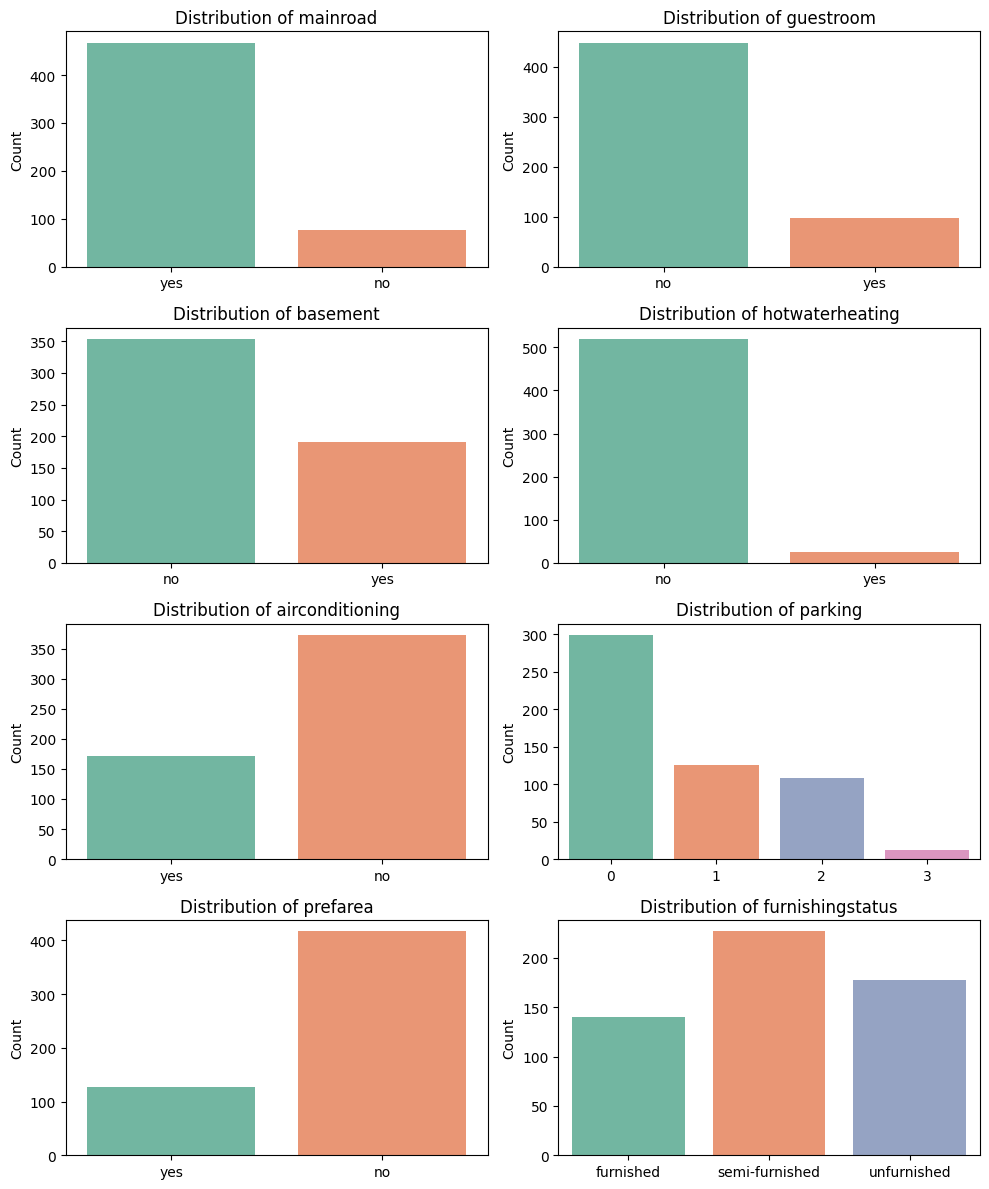

In [7]:
# plot the counts of the categorical variables
categorical_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
# Set up the plot grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_vars):
    sns.countplot(x=col, hue=col, data=df, ax=axes[i], palette='Set2', legend=False)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

- Majority of the houses are on a main road.  
- Majority of the houses are without a guest room.
- Majority of the houses are without a basement.
- Majority of the houses are without hot water supply.
- Majority of the houses are without air-conditioning.
- Most of the houses are without parking spaces.
- Majority of the houses are not in a preffered area.
- Most of the houses are semi-furnished.

#### Correlation Matrix

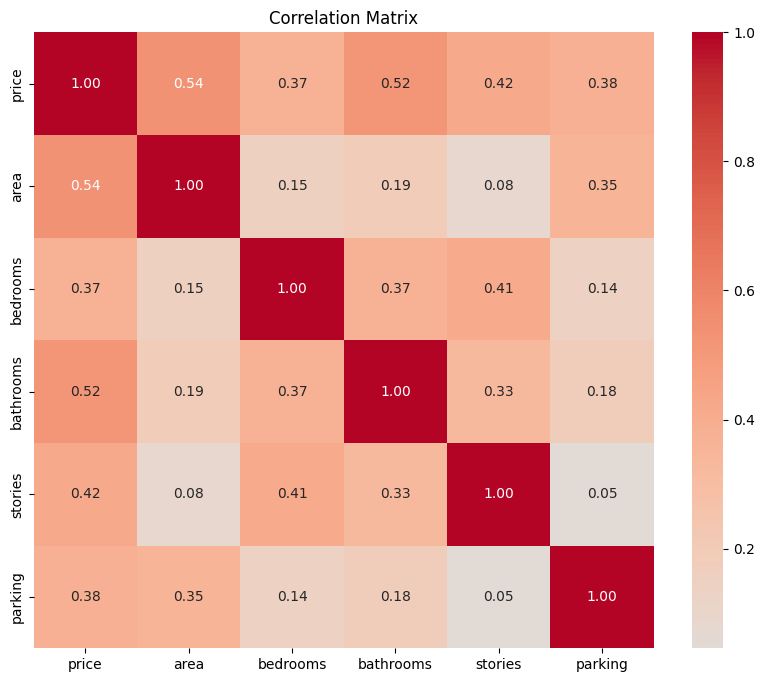

In [8]:
corr = df[['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix")
plt.show()

<b> Pairwise correlations show no strong linear relationships among the variables, though moderate correlations exist between price and total carpet area, number of bathrooms, and number of floors. </b>

#### Histograms

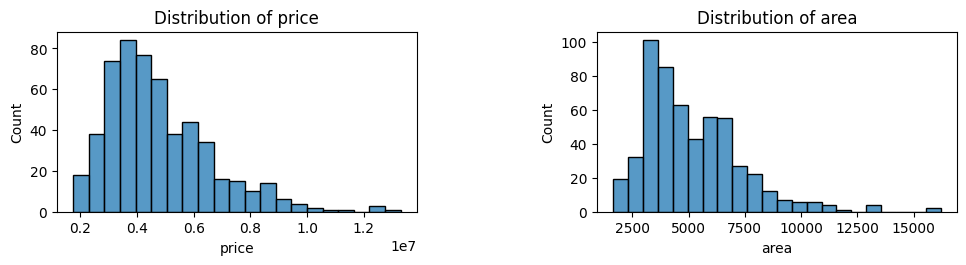

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)
sns.histplot(df['price']).set(title='Distribution of price')

plt.subplot(2,2,2)
sns.histplot(df['area']).set(title='Distribution of area')


plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

- Visual inspection of the histograms suggests departures from normality for price and area.

#### Scatterplot

<function matplotlib.pyplot.show(close=None, block=None)>

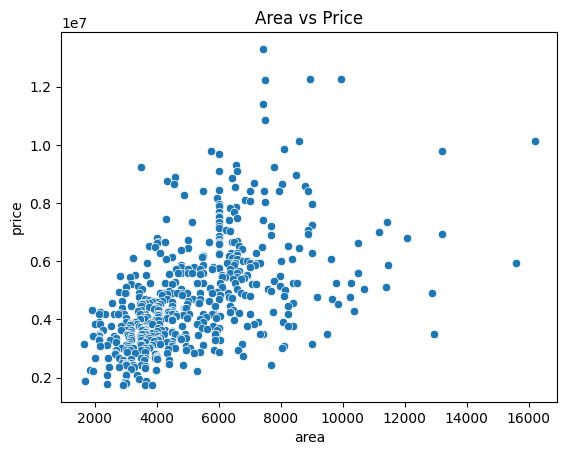

In [10]:
sns.scatterplot(x = 'area' , y='price',data =df)
plt.title('Area vs Price')
plt.show

- Majority of the houses are in the lower price range

#### Box-plots - Check For Outliers

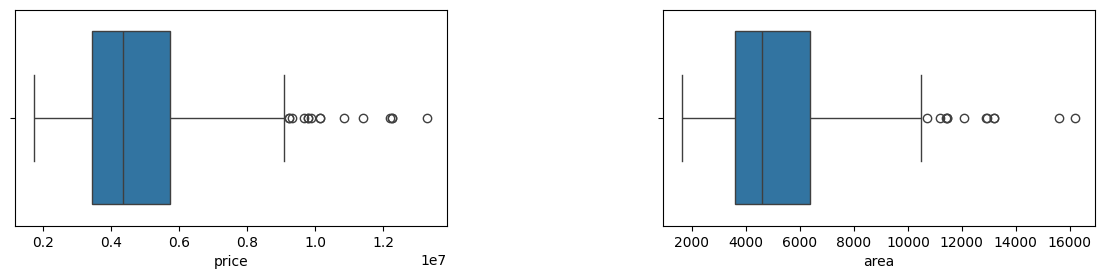

In [11]:
# Check for Outliers
plt.figure(figsize=(12, 6))
plt.subplot(2,2,1)
sns.boxplot(x = df['price'])

plt.subplot(2,2,2)
sns.boxplot(x = df['area'])

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.5, 
                    hspace=0.5)
plt.show()


- Observations beyond the whisker limits in both box plots indicate the presence of outliers in price and area.

### Remove Outliers

In [12]:
# Remove outliers using Winsorization(percentile capping)
continuos_vars = ['price', 'area', 'bedrooms', 'bathrooms', 'stories']
df = cap_outliers_percentile(df, continuos_vars)

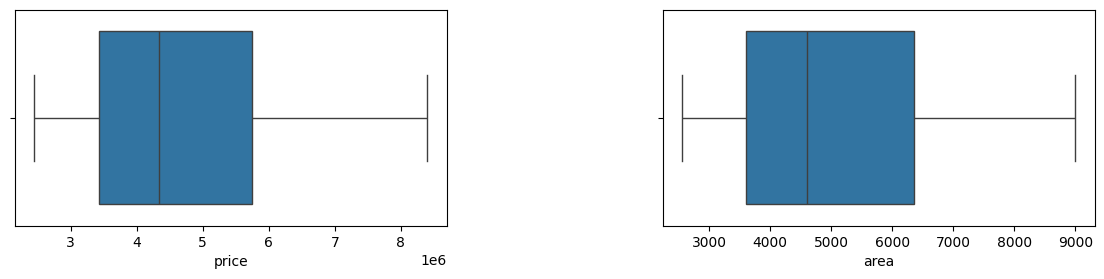

In [13]:
# Check for Outliers
plt.figure(figsize=(12, 6))
plt.subplot(2,2,1)
sns.boxplot(x = df['price'])

plt.subplot(2,2,2)
sns.boxplot(x = df['area'])

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.5, 
                    hspace=0.5)
plt.show()


- Winsorization via percentile capping removed all observed outliers.

### Encode data

In [14]:
cols_to_encode = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
df = label_encode_columns(df, cols_to_encode)

### Feature Engineering

In [15]:
df['bed_bath_ratio'] = df['bedrooms'] / df['bathrooms']
df['bed_stories_ratio'] = df['bedrooms'] / df['bathrooms']
df['bath_stories_ratio'] = df['bathrooms'] / df['stories']

### Split Data into Training, Validation, Testing

In [16]:
pred_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 
             'parking', 'prefarea', 'furnishingstatus', 'bed_bath_ratio', 'bed_stories_ratio', 'bath_stories_ratio']
target_col = "price"

X = df[pred_cols]
y = df[target_col]

# 70% train+val, 30% test
X_temp, X_test, y_temp, y_test = train_test_split(X, 
                                                  y, 
                                                  test_size=0.30, 
                                                  random_state=seed)

# Split train+val into train and validation (70/30 split of remaining)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.30, random_state=seed)

### Train Models

<b> Light GBM </b>

In [17]:
lgbm = LightGBM()
best_params = lgbm.tune_regressor(X=X_train, y=y_train)

tuned_lgbm_reg, best_params = lgbm.fit_regressor(X=X_train, y=y_train, best=best_params)
y_pred = tuned_lgbm_reg.predict(X_val)
lgbm_mae_val = lgbm.compute_mae(y_val, y_pred)
print(f"Validation MAE: {lgbm_mae_val}")

100%|██████████| 100/100 [01:05<00:00,  1.52trial/s, best loss: 728099.7470496403]
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

<b> Random Forest </b>

In [18]:
rf = RandomForest()
best_params = rf.tune_regressor(X=X_train, y=y_train)

tuned_rf_reg, best_params = rf.fit_regressor(X=X_train, y=y_train, best=best_params)
y_pred = tuned_rf_reg.predict(X_val)
rf_mae_val = rf.compute_mae(y_val, y_pred)
print(f"Validation MAE: {rf_mae_val}")

100%|██████████| 100/100 [01:49<00:00,  1.10s/trial, best loss: 741313.3323809754]
Validation MAE: 603962.2514189745


<b> XGBoost </b>

In [19]:
xg = XGBoost()
best_params_xg = xg.tune_regressor(X=X_train, y=y_train)

tuned_xg_reg, best_params = xg.fit_regressor(X=X_train, y=y_train, best=best_params_xg)
y_pred = tuned_xg_reg.predict(X_val)
xg_mae_val = xg.compute_mae(y_val, y_pred)
print(f"Validation MAE: {xg_mae_val}")

100%|██████████| 100/100 [00:28<00:00,  3.45trial/s, best loss: 738792.4]  
Validation MAE: 565803.4375


<b> Linear Regression </b>

In [20]:
lr = LinearRegressionModel()
best_params_lr = lr.tune_regressor(X=X_train, y=y_train)

tuned_lr_reg, best_params = lr.fit_regressor(X=X_train, y=y_train, best=best_params_lr)
y_pred = tuned_lr_reg.predict(X_val)
lr_mae_val = lr.compute_mae(y_val, y_pred)
print(f"Validation MAE: {lr_mae_val}")

100%|██████████| 100/100 [00:02<00:00, 49.02trial/s, best loss: 733440.752891312]
Validation MAE: 626235.8995692569


In [21]:
model_metrics = pd.DataFrame({
    'model_type': ['Random Forest', 'LightGBM', 'XGBoost', 'Linear Regression'],
    'MAE': [rf_mae_val, lgbm_mae_val, xg_mae_val, lr_mae_val]
})

model_metrics = model_metrics.sort_values(by='MAE', ascending=True).reset_index(drop=True)
display(model_metrics)

,model_type,MAE
0,XGBoost,565803.437500
1,Random Forest,603962.251419
2,LightGBM,612430.343414
3,Linear Regression,626235.899569


- XGBoost achieved the lowest Mean Absolute Error (MAE) among the models evaluated and was therefore selected as the final model for prediction

In [22]:
y_pred = tuned_xg_reg.predict(X_test)
xg_mae_test = xg.compute_mae(y_test, y_pred)
print(f"Test MAE: {xg_mae_test}")

Test MAE: 779917.0625


PermutationExplainer explainer: 165it [00:32,  4.47it/s]                         
C:\Users\syarn\AppData\Local\Temp\ipykernel_9472\3058097683.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


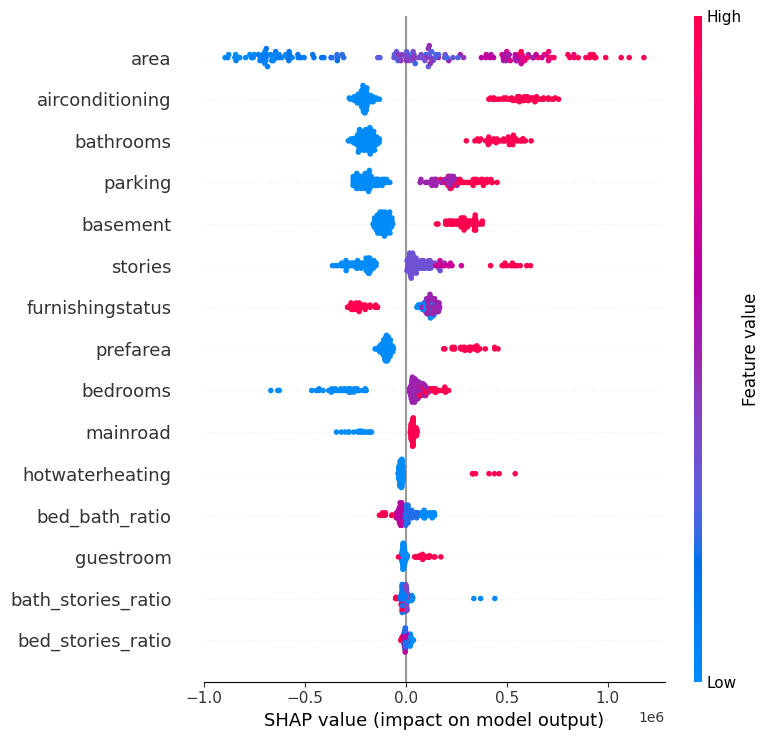

In [23]:
import shap

explainer = shap.Explainer(
    tuned_xg_reg.predict,
    X_train
)

shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

- SHAP results show that total carpet area, the presence of air conditioning, and the number of bathrooms are the primary drivers of the model’s predictions.